In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division
import six

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline
#matplotlib.rcParams['image.origin'] = 'lower'
#matplotlib.rcParams['image.interpolation'] = 'none'
#
## seaborn package for making pretty plots, but not necessary
#try:
#    import seaborn as sns
#    params =   {'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family': ['serif'],
#                'text.usetex': True, 'text.latex.preamble': ['\usepackage{gensymb}']}
#    sns.set_style("ticks", params)
#except ImportError:
#    print('Seaborn module is not installed.')
    
from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import (webbpsf, poppy, pix_noise, S)
pynrc.setup_logging('WARNING', verbose=False)

# Observation Definitions

In [3]:
def obs_wfe(wfe_drift, filt_list, sp_sci, dist, sp_ref=None):
    """
    For a given WFE drift and series of filters, create a list of 
    NIRCam observations. This function will calculate PSFs out to 10". 
    However, for the case of F200W+MASK335R, we will assume that the 
    subarray size matches that of a simultaneous LW observation (320x320).
    """
    if sp_ref is None:
        sp_ref = sp_sci
    
    filt_keys = []
    obs_dict = {}
    for filt, mask, pupil in filt_list:
        print(filt, mask, pupil)

        # Create identification keys
        if mask is None: mask = 'none'
        if pupil is None: pupil = 'none'
        key = '{}_{}_{}'.format(filt,mask,pupil)
        filt_keys.append(key)    

        # Set the PSF size and oversampling amount
        bp = pynrc.read_filter(filt)
        fov_pix = 640 if bp.avgwave()/1e4 < 2.5 else 320
        oversample = 2

        # Define the subarray readout size
        subsize = 640 if '210R' in mask else 320

        # Initialize and store the observation
        # A reference obseration is stored inside the parent obs_coronagraphy class.
        obs_dict[key] = pynrc.obs_coronagraphy(sp_sci, sp_ref, dist, wfe_drift=wfe_drift,
                                               filter=filt, mask=mask, pupil=pupil, 
                                               oversample=oversample, fov_pix=fov_pix,
                                               wind_mode='WINDOW', xpix=subsize, ypix=subsize)
    return obs_dict

In [4]:
def obs_optimize(obs_dict, sp_opt=None, tacq_max=1400, nint_min=15, ng_max=10, **kwargs):
    """
    Perform ramp optimization on each science and reference observation
    in a list of filter observations. Updates the detector MULTIACCUM
    settings for each observation in the dictionary.
    """

    # If sp_opt is not set, then default to a 20th magnitude flat source
    if sp_opt is None:
        bp_k = S.ObsBandpass('k')
        sp_opt = pynrc.stellar_spectrum('flat', 20, 'vegamag', bp_k)

    
    # Some observations may saturate, so define a list of  maximum well level
    # values that we will incrementally check until a ramp setting is found
    # that meets the contraints.
    well_levels = [0.8, 1.5, 2.0, 2.5, 3.0, 5.0, 10.0, 20.0, 100]
    # A very faint bg object on which to maximize S/N

   
    filt_keys = obs_dict.keys()
    filt_keys.sort()
    print(['Pattern', 'NGRP', 'NINT', 't_int', 't_exp', 't_acq', 'SNR', 'Well', 'eff'])
    for j, key in enumerate(filt_keys):
        print('')
        print(key)

        obs = obs_dict[key]
        sp_sci, sp_ref = (obs.sp_sci, obs.sp_ref)

        sci = obs
        ref = sci.nrc_ref
                
        # Ramp optimization for both science and reference targets
        for obs, sp in zip([sci, ref], [sp_sci, sp_ref]):
            i = nrow = 0
            while nrow==0:
                well_max = well_levels[i]
                tbl = obs.ramp_optimize(sp_opt, sp, tacq_max=tacq_max, tacq_frac=0.01, 
                                        nint_min=nint_min, ng_max=ng_max, 
                                        well_frac_max=well_max, ideal_Poisson=True,
                                        **kwargs)
                nrow = len(tbl)
                i+=1
                
            # Grab the highest ranked MULTIACCUM settings and update the detector readout
            v1, v2, v3 = tbl['Pattern', 'NGRP', 'NINT'][0]
            print(tbl[0].as_void())
            obs.update_detectors(read_mode=v1, ngroup=v2, nint=v3)
        

# HR 8799 Contrast Comparisons

In [5]:
# Science Target
# Argument tuple: (Name, distance, sptype model params, age, kmag)
args_sci = ('HR 8799',   39.0, (7430, -0.47, 4.35),  100,  5.24)
name, dist, sp_args, age, kmag = args_sci

bp_k = S.ObsBandpass('k')
sp = S.Icat('ck04models', *sp_args)
sp_sci = sp.renorm(kmag, 'vegamag', bp_k)
sp_sci.name = name


# Reference Star
# Argument tuple: (Name, distance, sptype model params, age, kmag)
args_ref = ('HD 220657', 52.2, (5888, -0.01, 3.22), 1000,  3.04)
name, dist, sp_args, age, kmag = args_ref

sp = S.Icat('ck04models', *sp_args)
sp_ref = sp.renorm(kmag, 'vegamag', bp_k)
sp_ref.name = name

In [6]:
# HR8799 planet magnitudes
# [b, c, d, e]
planet_mags = {'F210M': np.array([17.0, 16.1, 16.1, 15.9]),
               'F200W': np.array([17.0, 16.1, 16.1, 15.9]),
               'F335M': np.array([16.2, 15.2, 15.0, 15.1]),
               'F356W': np.array([15.6, 14.7, 14.5, 14.6]),
               'F430M': np.array([15.8, 14.9, 14.5, 14.6]),
               'F444W': np.array([16.0, 15.0, 14.6, 14.7])}

# Locations
loc_list = [(-1.57,  0.71), ( 0.52,  0.79), ( 0.39, -0.53), ( 0.38,  0.01)]
planet_dist = np.array([np.sqrt(x**2+y**2) for x,y in loc_list])

## 1. Compare MASK335R vs. MASK430R

It might be worthwhile to always use the 335R circular mask instead of the 430R and 210R masks.
 1. Avoids overheads associated with switching between 430R and 335R
 2. Enables simulataneous SW/LW imaging
 
Here, we compare the resulting contrast curves for wide band filters paired with two mask options to test if MASK335R is an acceptable replacement.

In [7]:
# List of filters
args_list = [('F200W', 'MASK210R', 'CIRCLYOT'),
             ('F200W', 'MASK335R', 'CIRCLYOT'),
             ('F444W', 'MASK335R', 'CIRCLYOT'),
             ('F444W', 'MASK430R', 'CIRCLYOT')]

filt_keys = []
for filt,mask,pupil in args_list:
    key = '{}_{}_{}'.format(filt,mask,pupil)
    filt_keys.append(key) 

In [8]:
wfe_drift = 10
obs_dict = obs_wfe(wfe_drift, args_list, sp_sci, dist, sp_ref)

F200W MASK210R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F200W MASK335R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F444W MASK335R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F444W MASK430R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.


In [9]:
# Find best ramp settings and update
# Settings are for a single roll angle
obs_optimize(obs_dict)

['Pattern', 'NGRP', 'NINT', 't_int', 't_exp', 't_acq', 'SNR', 'Well', 'eff']

F200W_MASK210R_CIRCLYOT
(u'BRIGHT2', 6, 25, 50.23008, 1255.752, 1360.887, 22.939839621576777, 0.7398963584512521, 0.621)


[     pynrc:WARNING] No ramp settings allowed within constraints! Reduce constraints.


(u'RAPID', 3, 82, 12.55752, 1029.71664, 1374.5594399999998, 5.458843757272186, 1.4054133613956015, 0.147)

F200W_MASK335R_CIRCLYOT
(u'MEDIUM8', 9, 15, 94.07552, 1411.1327999999999, 1427.4672, 51.71227840896199, 0.49574526641408106, 1.368)
(u'BRIGHT2', 9, 68, 19.24272, 1308.50496, 1382.55424, 18.260098279143456, 0.758868367274469, 0.491)

F444W_MASK335R_CIRCLYOT
(u'MEDIUM8', 9, 15, 94.07552, 1411.1327999999999, 1427.4672, 94.82993126468895, 0.296122708792447, 2.509)
(u'SHALLOW4', 6, 43, 31.00216, 1333.09288, 1379.91816, 63.93378967609667, 0.7471090091068583, 1.721)

F444W_MASK430R_CIRCLYOT
(u'MEDIUM8', 9, 15, 94.07552, 1411.1327999999999, 1427.4672, 94.82993126468895, 0.12670657830845308, 2.509)
(u'MEDIUM8', 7, 18, 72.69472, 1308.50496, 1328.10624, 86.07933254806422, 0.743730419039155, 2.362)


In [10]:
# Generate and store contrast curves for each science and reference observation
rr_list       = [] # Radial distances
contrast_list = [] # Contrasts w.r.t. radial distance
magsens_list  = [] # Sensitivities w.r.t. radial distance

filt_keys = obs_dict.keys()
filt_keys.sort()
nsig = 5
roll_angle = 10
for key in filt_keys:
    print(key)
    obs = obs_dict[key]
    
    rr, contrast, magsens = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig)
    rr_list.append(rr)
    contrast_list.append(contrast)
    magsens_list.append(magsens)

F200W_MASK210R_CIRCLYOT
F200W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


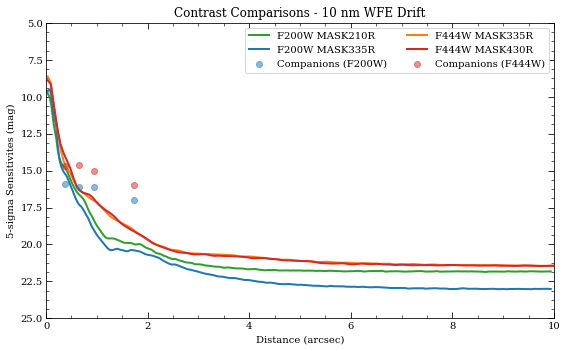

In [18]:
# Plot sensitivity curves along with location of companions
fig, ax = plt.subplots(figsize=(8,5))
colors = ['C2', 'C0', 'C1', 'C3']

nsig = 5
for i, mag_sens in enumerate(magsens_list):
    rr = rr_list[i]
    filt, mask, pupil = args_list[i]
        
    # Plot contrast curves
    label="{} {}".format(filt,mask)
    ax.plot(rr, mag_sens, lw=2, label=label, color=colors[i])

    # Plot observed companion magnitudes
    pmag = planet_mags.get(filt)
    if i==1 or i==3:
        label = 'Companions ({})'.format(filt)
        ax.plot(planet_dist, pmag, marker='o', ls='None', label=label, 
                color=colors[i], alpha=0.5, zorder=10)
    
ax.legend(ncol=2)
ax.set_title('Contrast Comparisons - {} nm WFE Drift'.format(wfe_drift))
ax.set_xlabel('Distance (arcsec)')
ax.set_ylabel('{}-sigma Sensitivites (mag)'.format(nsig))
ax.set_xlim([0,10])
ax.set_ylim([25,5])
#ax.set_ylim([2e-9,2e-5])
ax.minorticks_on()

fig.tight_layout()

It appears that there isn't much of a trade-off between MASK335R and MASK430R with regards to F444W.

However, for F200W, you can get high sensitivity with MASK335R, because the mask blocks out more light so we don't saturate as quickly. Therefore, we are able to use more favorable MULTIACCUM ramps to reduce the read noise.

## 2. Create images

For a series of filters, generate some slope images.

In [7]:
# List of filters
args_list = [('F210M', 'MASK335R', 'CIRCLYOT'),
             ('F335M', 'MASK335R', 'CIRCLYOT'),
             ('F430M', 'MASK335R', 'CIRCLYOT'), 
             ('F200W', 'MASK335R', 'CIRCLYOT'),
             ('F356W', 'MASK335R', 'CIRCLYOT'), 
             ('F444W', 'MASK335R', 'CIRCLYOT')]

filt_keys = []
for filt,mask,pupil in args_list:
    key = '{}_{}_{}'.format(filt,mask,pupil)
    filt_keys.append(key) 

In [8]:
# Create a list of observations of each filter
wfe_drift = 10
obs_dict = obs_wfe(wfe_drift, args_list, sp_sci, dist, sp_ref)

F210M MASK335R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F335M MASK335R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F430M MASK335R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F200W MASK335R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F356W MASK335R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F444W MASK335R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.


In [9]:
# Optimize MULTIACCUM settings
obs_optimize(obs_dict, patterns=['BRIGHT2', 'MEDIUM8', 'SHALLOW4'])

['Pattern', 'NGRP', 'NINT', 't_int', 't_exp', 't_acq', 'SNR', 'Well', 'eff']

F200W_MASK335R_CIRCLYOT
('MEDIUM8', 9, 15, 94.07552, 1411.1327999999999, 1427.4672, 51.71227840896199, 0.49574526641408106, 1.368)
('BRIGHT2', 9, 68, 19.24272, 1308.50496, 1382.55424, 18.260098279143456, 0.758868367274469, 0.491)

F210M_MASK335R_CIRCLYOT
('MEDIUM8', 9, 15, 94.07552, 1411.1327999999999, 1427.4672, 29.63981651453916, 0.26647081056941524, 0.784)
('SHALLOW4', 7, 37, 36.34736, 1344.85232, 1385.1438400000002, 15.023355091556319, 0.7956207087427796, 0.403)

F335M_MASK335R_CIRCLYOT
('MEDIUM8', 9, 15, 94.07552, 1411.1327999999999, 1427.4672, 53.77472957479904, 0.2597073725198328, 1.423)
('SHALLOW4', 7, 37, 36.34736, 1344.85232, 1385.1438400000002, 33.93564482635513, 0.7758483713951982, 0.911)

F356W_MASK335R_CIRCLYOT
('MEDIUM8', 9, 15, 94.07552, 1411.1327999999999, 1427.4672, 97.6906378514116, 0.41585452634922915, 2.585)
('BRIGHT2', 10, 61, 21.3808, 1304.2288, 1370.6553599999997, 53.22631022735703, 0.

In [10]:
# For each obs configuration, add planet information
for k in filt_keys:
    obs = obs_dict[k]
    mags = planet_mags[obs.filter]
    for loc, mag in zip(loc_list, mags):
        renorm_args = (mag, 'vegamag', obs.bandpass)
        obs.add_planet(loc=loc, loc_units='asec', age=50, entropy=13, mass=10, renorm_args=renorm_args)

Try a couple different parallactic angles (210-220 vs 240-250)

In [11]:
# Generate a list of roll-subtracted slope images, one for each filter
# PA rolls of 210 to 220 deg
final_hdus = []
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    res = obs.gen_roll_image(PA1=210, PA2=220, oversample=2)
    final_hdus.append(res)

F210M_MASK335R_CIRCLYOT
F335M_MASK335R_CIRCLYOT
F430M_MASK335R_CIRCLYOT
F200W_MASK335R_CIRCLYOT
F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [12]:
loc_list

[(-1.57, 0.71), (0.52, 0.79), (0.39, -0.53), (0.38, 0.01)]

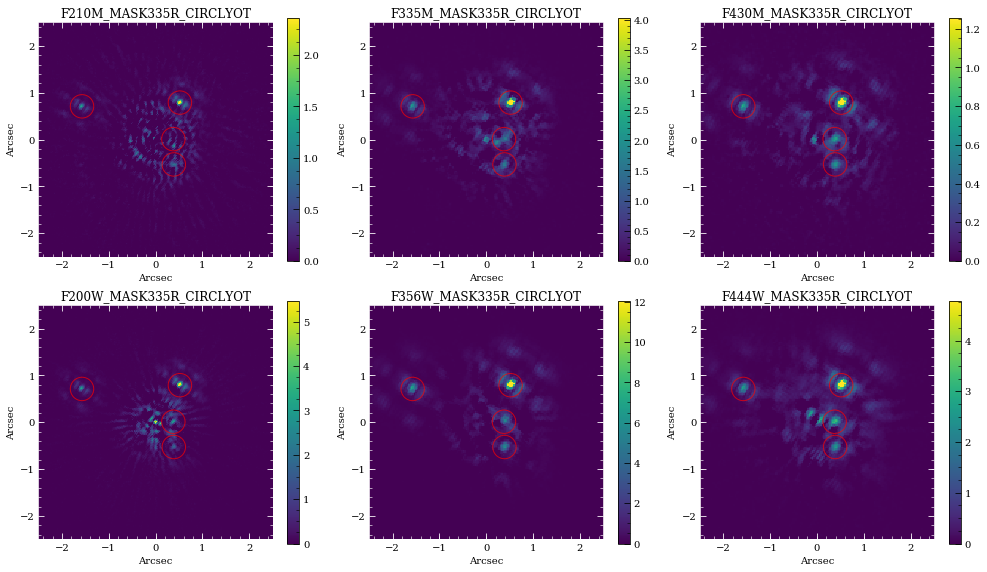

In [13]:
fig, axes = plt.subplots(2,3, figsize=(14,8))
axes = axes.flatten()

#cmap = sns.cubehelix_palette(start=0, rot=0.5, light=1, as_cmap=True)
cmap = matplotlib.rcParams['image.cmap']
for i, ax in enumerate(axes):
    hdulist = final_hdus[i]
    data = hdulist[0].data
    
    vmax = data.max() * 0.75
    #vmax = np.ceil(vmax)
    vmin = 0#np.min([0,data.min()])
    ax, cb = webbpsf.display_psf(hdulist, ax=ax, title=filt_keys[i], colorbar=True, cmap=cmap,
                                 scale='linear', vmin=vmin, vmax=vmax, imagecrop=5, return_ax=True)
    cb.set_label('')
    
    for loc in loc_list:
        circle = matplotlib.patches.Circle(loc, 0.25, alpha=0.7, lw=1, \
                                           edgecolor='red', facecolor='none')
        ax.add_artist(circle)

    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')
    
    ax.minorticks_on()

    #ax.axhline(0, ls=':', color='white', alpha=0.5, lw=3)
    #ax.axvline(0, ls=':', color='white', alpha=0.5, lw=3)

    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')


fig.tight_layout()

In [14]:
# Generate a list of roll-subtracted slope images, one for each filter
# PA rolls of 240 to 220 deg
final_hdus = []
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    res = obs.gen_roll_image(PA1=240, PA2=250, oversample=2)
    final_hdus.append(res)

F210M_MASK335R_CIRCLYOT
F335M_MASK335R_CIRCLYOT
F430M_MASK335R_CIRCLYOT
F200W_MASK335R_CIRCLYOT
F356W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


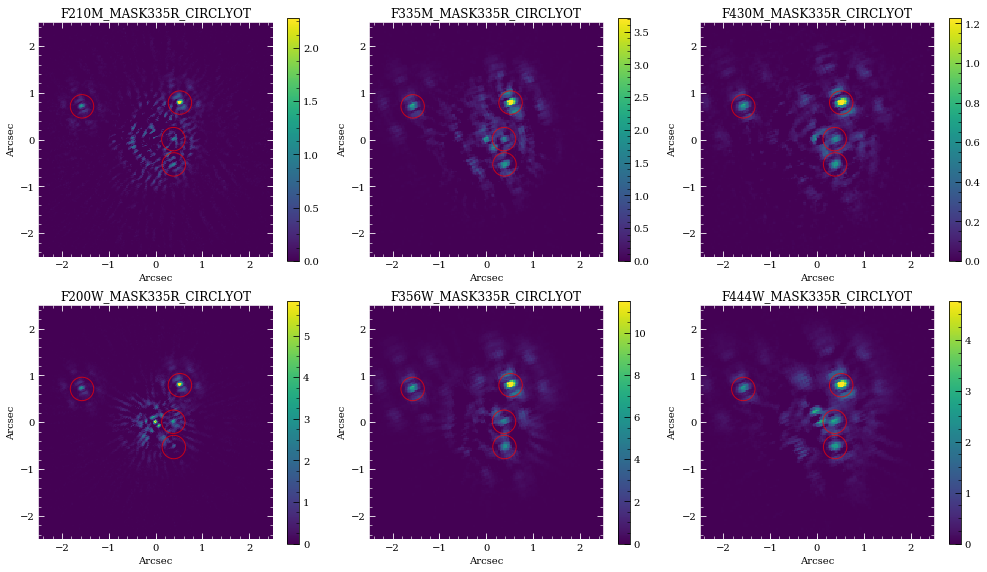

In [15]:
fig, axes = plt.subplots(2,3, figsize=(14,8))
axes = axes.flatten()

#cmap = sns.cubehelix_palette(start=0, rot=0.5, light=1, as_cmap=True)
cmap = matplotlib.rcParams['image.cmap']
for i, ax in enumerate(axes):
    hdulist = final_hdus[i]
    data = hdulist[0].data
    
    vmax = data.max() * 0.75
    vmin = 0
    ax, cb = webbpsf.display_psf(hdulist, ax=ax, title=filt_keys[i], colorbar=True, cmap=cmap,
                                 scale='linear', vmin=vmin, vmax=vmax, imagecrop=5, return_ax=True)
    cb.set_label('')
    
    for loc in loc_list:
        circle = matplotlib.patches.Circle(loc, 0.25, alpha=0.7, lw=1, \
                                           edgecolor='red', facecolor='none')
        ax.add_artist(circle)

    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')
    
    ax.minorticks_on()

    #ax.axhline(0, ls=':', color='white', alpha=0.5, lw=3)
    #ax.axvline(0, ls=':', color='white', alpha=0.5, lw=3)

    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')


fig.tight_layout()

### Compare WFE Drifts

Using the 335R mask, compare the contrasts for different levels of WFE drift.

In [16]:
# List of filters
args_list = [('F210M', 'MASK335R', 'CIRCLYOT'),
             ('F200W', 'MASK335R', 'CIRCLYOT'),
             ('F335M', 'MASK335R', 'CIRCLYOT'),
             ('F356W', 'MASK335R', 'CIRCLYOT'), 
             ('F430M', 'MASK335R', 'CIRCLYOT'), 
             ('F444W', 'MASK335R', 'CIRCLYOT')]

filt_keys = []
for filt,mask,pupil in args_list:
    key = '{}_{}_{}'.format(filt,mask,pupil)
    filt_keys.append(key) 

In [17]:
# Generate initial observations (no WFE drift)
obs_dict = obs_wfe(0, args_list, sp_sci, dist, sp_ref)

F210M MASK335R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F200W MASK335R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F335M MASK335R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F356W MASK335R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F430M MASK335R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F444W MASK335R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.


In [18]:
# Optimize each observation only once
obs_optimize(obs_dict, patterns=['BRIGHT2', 'MEDIUM8', 'SHALLOW4'])

['Pattern', 'NGRP', 'NINT', 't_int', 't_exp', 't_acq', 'SNR', 'Well', 'eff']

F200W_MASK335R_CIRCLYOT
('MEDIUM8', 9, 15, 94.07552, 1411.1327999999999, 1427.4672, 51.71227840896199, 0.49574526641408106, 1.368)
('BRIGHT2', 9, 68, 19.24272, 1308.50496, 1382.55424, 18.246866276376803, 0.7682735751247322, 0.49)

F210M_MASK335R_CIRCLYOT
('MEDIUM8', 9, 15, 94.07552, 1411.1327999999999, 1427.4672, 29.63981651453916, 0.26647081056941524, 0.784)
('SHALLOW4', 7, 37, 36.34736, 1344.85232, 1385.1438400000002, 15.028409002100844, 0.7796349334075967, 0.403)

F335M_MASK335R_CIRCLYOT
('MEDIUM8', 9, 15, 94.07552, 1411.1327999999999, 1427.4672, 53.77472957479904, 0.2597073725198328, 1.423)
('SHALLOW4', 7, 37, 36.34736, 1344.85232, 1385.1438400000002, 33.91257496504579, 0.7724658481860112, 0.911)

F356W_MASK335R_CIRCLYOT
('MEDIUM8', 9, 15, 94.07552, 1411.1327999999999, 1427.4672, 97.6906378514116, 0.41585452634922915, 2.585)
('BRIGHT2', 10, 61, 21.3808, 1304.2288, 1370.6553599999997, 53.202267268502425, 0

In [19]:
#Cycle through varying levels of WFE drift and calculate contrasts
wfe_list = [0,1,2,5,10]
nsig = 5
roll_angle = 10

contrast_all = []
for i, wfe_drift in enumerate(wfe_list):
    print(wfe_drift)
    # Generate series of observations for each filter
    for key in filt_keys:
        obs_dict[key].wfe_drift = wfe_drift
            
    # Generate contrast curves
    curves = []
    for key in filt_keys:
        obs = obs_dict[key]
        # result is a tuple (distance, contrast)
        result = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig)
        curves.append(result)
    contrast_all.append(curves)

0
1
2
5
10


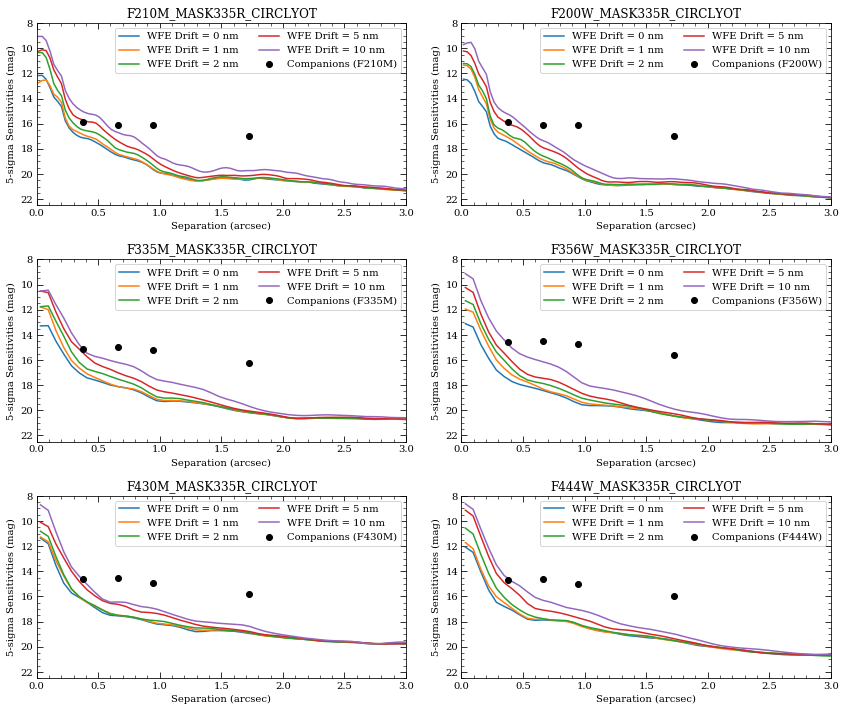

In [20]:
fig,axes = plt.subplots(3,2, figsize=(12,10))
# Plot contrast curves
for j, contrasts in enumerate(contrast_all):
    for i,ax in enumerate(axes.flatten()):
        rr, contrast, mag_sens = contrasts[i]
        label="WFE Drift = {} nm".format(wfe_list[j])
        ax.plot(rr, mag_sens, label=label)

for i,ax in enumerate(axes.flatten()):
    filt, mask, pupil = args_list[i]
    pmag = planet_mags.get(filt)
    label = 'Companions ({})'.format(filt)
    ax.plot(planet_dist, pmag, marker='o', ls='None', label=label, color='k', zorder=10)

    
    ax.set_xlim([0,3])
    ax.set_ylim([22.5,8])
    ax.minorticks_on()
    ax.set_title(filt_keys[i])
    ax.legend(ncol=2)
    
    ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))
    ax.set_xlabel('Separation (arcsec)')
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.15)